In [1]:
# tutorial from https://huggingface.co/docs/transformers/en/model_doc/vitpose
#from transformers.models.vitpose import VitPoseForPoseEstimation, VitPoseImageProcessor
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
import torch
import requests
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [13]:
url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365") # loads a preprocessing pipeline img (to ensure same preproc.g)
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device) # loads the object detection model:  RT-DETR object detection model (detectiion + label.g -> label 0 = person)
inputs = person_image_processor(images=image, return_tensors="pt").to(device) # preprocesses the image and returns it as a tensor
# returns an object of type <class 'transformers.image_processing_base.BatchFeature'> -> behaves like a dict e.g. inputs.keys() -> 'pixel_values' i.e. the normalized img tensor of shape 2, 3, 256, 192



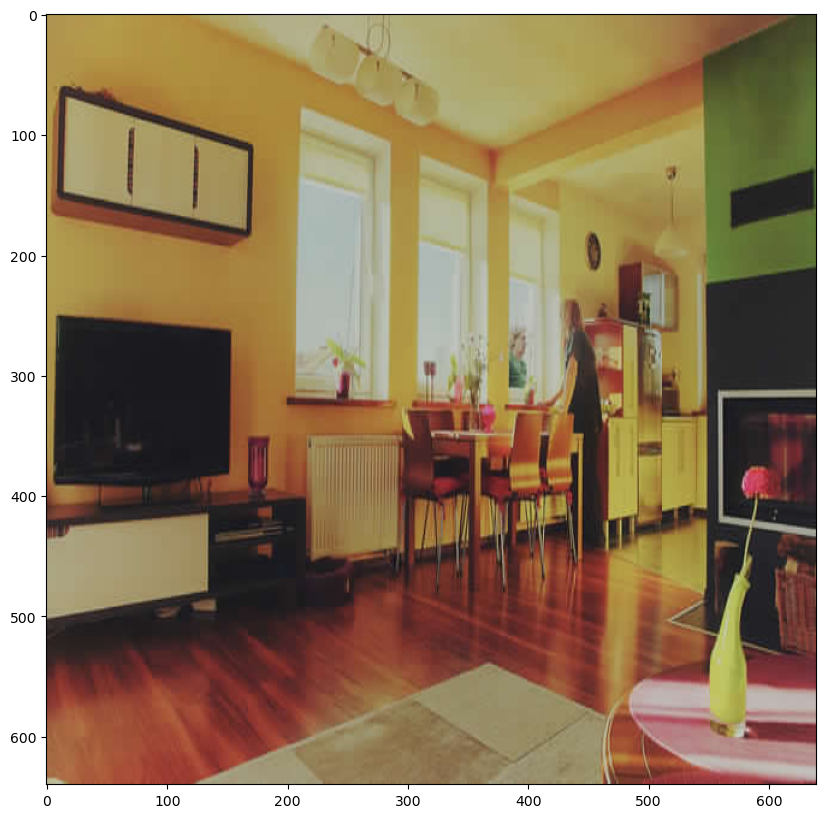

In [11]:
# to see the preprocessed img
img = inputs["pixel_values"][0, :,:,:]
img_np = img.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(img_np)

In [15]:
with torch.no_grad():
    outputs = person_model(**inputs) # performs object detection on the input

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3 
) # converts raw model outputs into interpretable bounding box predictions 
# parameters:
# - (image.height, image.width) -> the original dimensions of the img to rescale the boxes accordingly
# - threshold=.3 -> keeps only the high confidence detections
# results is a list with 1 element, a dict, with the following entries: 
# 'scores' (a tensor with the confidences), 
# 'labels' (a tensor with the lables detected)
# 'boxes' (a tensor with the boxes corners)

result = results[0] # selects the first element in the list
person_boxes = result["boxes"][result["labels"] == 0] # index only the boxes associated with label 0 (person) in COCO class labels
person_boxes = person_boxes.cpu().numpy() # converts them to numpy
# converts boxes from VOC format: (x1, y1, x2, y2) to COCO format: N pers detected x 4 -> 4 cols are => (x, y, width, height)
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0] 
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1] 

In [16]:
print(person_boxes)

[[418.03467  157.3076    45.815277 139.43831 ]]


In [17]:
result

{'scores': tensor([0.9375, 0.8901, 0.8693, 0.8616, 0.8342, 0.7942, 0.6893, 0.6876, 0.6434,
         0.6264, 0.6176, 0.5987, 0.5454, 0.5145, 0.5142, 0.4437, 0.4099, 0.3920,
         0.3339, 0.3296, 0.3268, 0.3257, 0.3217, 0.3188, 0.3060]),
 'labels': tensor([62, 56, 56, 75,  0, 56, 75, 60, 58, 72, 74, 72, 75, 62, 75, 58, 56, 39,
         72, 60, 60, 58, 58, 68, 56]),
 'boxes': tensor([[  5.4415, 166.2207, 154.9481, 262.4288],
         [295.3667, 218.0322, 352.5346, 319.4936],
         [363.5578, 219.2370, 415.8479, 319.2986],
         [550.6843, 299.6902, 586.8405, 400.6440],
         [418.0347, 157.3076, 463.8499, 296.7459],
         [408.2327, 219.2469, 442.0942, 309.6992],
         [241.6385, 198.0929, 253.1721, 213.1244],
         [320.1023, 227.2238, 444.7830, 319.2638],
         [227.4684, 177.1051, 267.3431, 213.3844],
         [491.0170, 173.6138, 512.7244, 284.1328],
         [448.5083, 120.2380, 461.3460, 142.0998],
         [490.8826, 173.1045, 512.7081, 284.2324],
         [

In [18]:
# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple") # downloads a processor tailored for the vitpose-base-simple model, it resizes, normalizes, and formats input data (cropping each detected person), automatically includes COCO keypoint configuration.
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device) #downloads ViTPose

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device) # processes the original image using the bounding boxes -> ViTPose expects tightly cropped pics
# inputs is a dict like type with "pixels_value" as only entry. It is a tensor [Batch, Channels, Height, Width] -> Batch is the number of people detected

with torch.no_grad():
    outputs = model(**inputs) # runs ViTPose

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes]) 
# pose results is a list (len=1, num of images passed) of lists (len=Batch_size=people detected). 
# Each element is a dict with:
# - 'keypoints' -> the 2d coords of the keypoints within the img ref frame
# - 'scores' -> the confidence of each of the keypoints
# - 'labels' -> the labels of the keypoints , model.config.label2id to see the correspondence 
# - 'bbox' -> contours of the boxes 

image_pose_result = pose_results[0]  

In [19]:
torch.Tensor.size(inputs["pixel_values"])

torch.Size([1, 3, 256, 192])

In [20]:
print(pose_results[0][0])
print(len(pose_results[0]))

{'keypoints': tensor([[429.1591, 169.1448],
        [430.4791, 166.3249],
        [429.4732, 166.4640],
        [435.1031, 166.9077],
        [442.2527, 167.3099],
        [440.2661, 179.5420],
        [447.9133, 180.3297],
        [437.3762, 199.1478],
        [430.3440, 206.0780],
        [432.6058, 216.7646],
        [418.4463, 214.2251],
        [443.8008, 222.0954],
        [452.3930, 221.7840],
        [442.0421, 254.7931],
        [451.0377, 253.9766],
        [442.9174, 287.1783],
        [454.2697, 284.4849]]), 'scores': tensor([0.8966, 0.8995, 0.7580, 0.8974, 0.9248, 0.9173, 0.8137, 0.8577, 0.3395,
        0.8098, 0.8648, 0.7885, 0.7927, 0.8082, 0.7677, 0.6485, 0.7471]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([440.9423, 227.0268, 440.5959, 226.8983])}
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


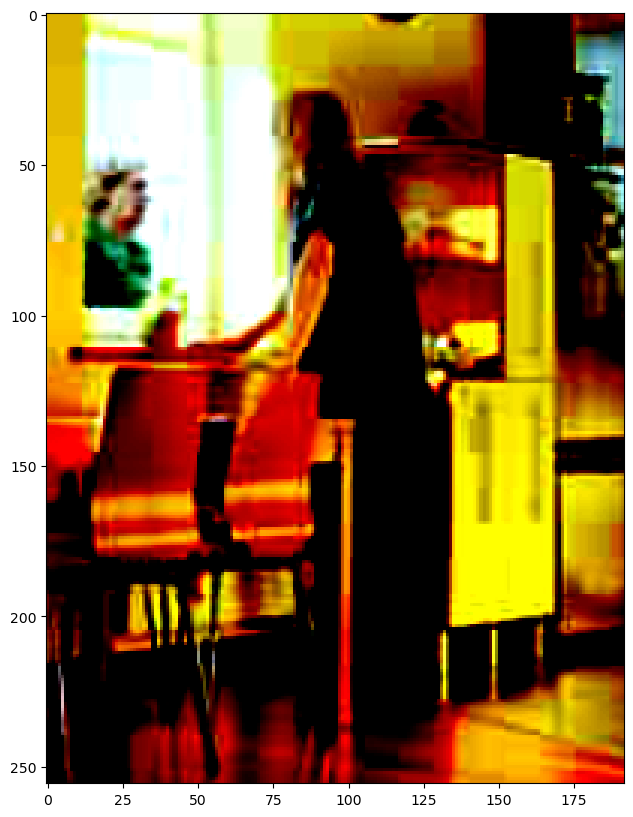

In [22]:
# to see what are the inputs to the model
img = inputs["pixel_values"][0, :,:,:]
img_np = img.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(img_np)

In [23]:
torch.Tensor.size(inputs["pixel_values"])

torch.Size([1, 3, 256, 192])

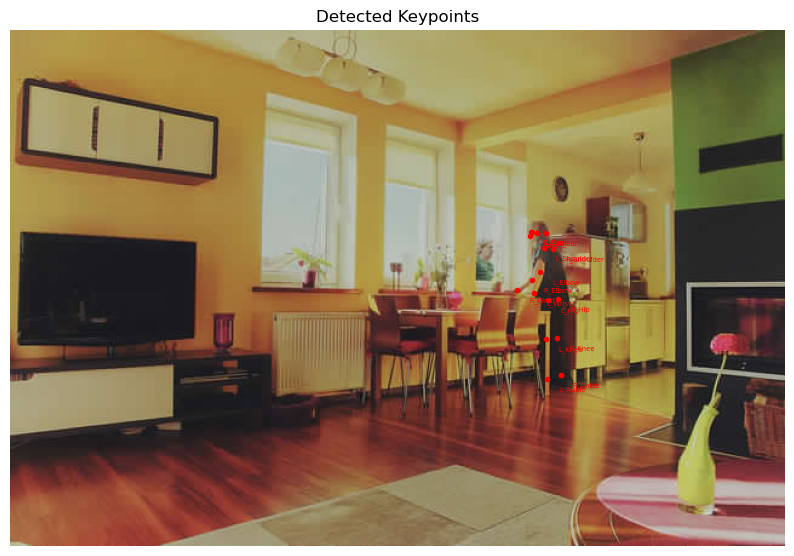

In [27]:
def plot_pose(image, boxes, img_pose_res, pers_indices, model):
    keypoint_labels = model.config.label2id 
    label_names = {v: k for k, v in keypoint_labels.items()} # reverts keys and vals of the labels so that we can retrieve properly the label names
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for pers_idx in pers_indices:
        box = boxes[pers_idx]
        keypoints = img_pose_res[pers_idx]["keypoints"]
        labels_kp = img_pose_res[pers_idx]["labels"]
        for kp_idx in range(keypoints.size()[0]):
            kps = keypoints[kp_idx, :].numpy()
            plt.plot(kps[0], kps[1], 'ro', markersize=3)
            plt.text(kps[0]+10, kps[1]+10, label_names[labels_kp[kp_idx].item()], color="red", fontsize=5)
        # # Optionally draw bounding box
        # x, y, w, h = box
        # rect = plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=1)
        # plt.gca().add_patch(rect)
    
    plt.axis('off')
    plt.title("Detected Keypoints")
    plt.show()

plot_pose(image, person_boxes, image_pose_result, [0], model)

In [29]:
model.config.label2id 

{'L_Ankle': 15,
 'L_Ear': 3,
 'L_Elbow': 7,
 'L_Eye': 1,
 'L_Hip': 11,
 'L_Knee': 13,
 'L_Shoulder': 5,
 'L_Wrist': 9,
 'Nose': 0,
 'R_Ankle': 16,
 'R_Ear': 4,
 'R_Elbow': 8,
 'R_Eye': 2,
 'R_Hip': 12,
 'R_Knee': 14,
 'R_Shoulder': 6,
 'R_Wrist': 10}

In [ ]:
image_pose_result[0]["keypoints"].size()[0]

In [ ]:
person_boxes